# Statistical Arbitrage ML Strategy - Complete Training & Evaluation

This notebook provides a comprehensive workflow for:
1. Data acquisition and preprocessing
2. Feature engineering and analysis
3. Model training with multiple algorithms
4. Model evaluation and comparison
5. Feature importance analysis
6. Portfolio construction simulation
7. Performance visualization

**Note**: This is the complete training pipeline. For backtesting, use QuantConnect Lean (see lean/ directory).

In [1]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Import strategy modules
from src.data_acquisition import DataAcquisitionEngine
from src.feature_engineering import FeatureEngineer
from src.model_trainer import ModelTrainer
from src.portfolio_builder import PortfolioBuilder
from src.utils import calculate_sharpe_ratio, calculate_max_drawdown

# Plotting setup
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['font.size'] = 10

%matplotlib inline

print("✓ All modules imported successfully")

✓ All modules imported successfully


## 1. Configuration and Setup

Define the parameters for data acquisition, feature engineering, and model training.

In [2]:
# Strategy Configuration
CONFIG = {
    'data': {
        'universe_size': 200,  # Increased to ensure 40+ stocks per date after filtering
        'train_years': 20,     # Years of training data
        'test_years': 1,       # Years of test data
        'min_price': 5.0,      # Minimum stock price
        'min_volume': 1e6,     # Minimum daily volume
    },
    'features': {
        'momentum_periods': [5, 10, 20, 60, 126, 252],
        'ma_periods': [10, 20, 50, 100, 200],
        'volatility_window': 20,
    },
    'models': {
        'types_to_test': ['ridge', 'random_forest', 'xgboost', 'lightgbm'],
        'cv_folds': 5,
        'validation_split': 0.2,
    },
    'portfolio': {
        'n_long': 20,
        'n_short': 20,
        'max_position_size': 0.04,  # 4% max per position
        'holding_days': 3,
    }
}

print("Configuration:")
for key, value in CONFIG.items():
    print(f"\n{key.upper()}:")
    for k, v in value.items():
        print(f"  {k}: {v}")

Configuration:

DATA:
  universe_size: 200
  train_years: 20
  test_years: 1
  min_price: 5.0
  min_volume: 1000000.0

FEATURES:
  momentum_periods: [5, 10, 20, 60, 126, 252]
  ma_periods: [10, 20, 50, 100, 200]
  volatility_window: 20

MODELS:
  types_to_test: ['ridge', 'random_forest', 'xgboost', 'lightgbm']
  cv_folds: 5
  validation_split: 0.2

PORTFOLIO:
  n_long: 20
  n_short: 20
  max_position_size: 0.04
  holding_days: 3


## 2. Data Acquisition

Download historical data for the Russell 3000 universe with survivorship-bias-free filtering.

In [3]:
# Initialize data engine
data_engine = DataAcquisitionEngine(data_dir='../data', cache_enabled=True)
universe = data_engine.get_russell_3000_universe()[:CONFIG['data']['universe_size']]
print(f"Universe size: {len(universe)} stocks")
print(f"Sample tickers: {universe[:10]}")

2026-01-23 18:28:00.115 | INFO     | src.data_acquisition:__init__:40 - DataAcquisitionEngine initialized with cache at ../data
2026-01-23 18:28:00.116 | WARNING  | src.data_acquisition:get_russell_3000_universe:62 - Using sample universe. Implement actual Russell 3000 API for production.


Universe size: 200 stocks
Sample tickers: ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META', 'TSLA', 'AVGO', 'ORCL', 'ADBE']


In [4]:
# Calculate date range
end_date = datetime.now()
start_date = end_date - timedelta(days=365 * (CONFIG['data']['train_years'] + CONFIG['data']['test_years']))

print(f"Date range: {start_date.date()} to {end_date.date()}")
print(f"Total period: {(end_date - start_date).days / 365:.1f} years")

# Download data
print("\nDownloading historical data...")
df_raw = data_engine.get_training_data(
    tickers=universe,
    start_date=start_date,
    end_date=end_date,
    apply_filters=True
)

# Check index structure and report
print(f"\n✓ Downloaded data: {len(df_raw):,} rows")

# Handle different index structures
if isinstance(df_raw.index, pd.MultiIndex):
    # MultiIndex case
    index_names = df_raw.index.names
    print(f"  Index levels: {index_names}")
    
    # Get ticker count
    ticker_level = 'ticker' if 'ticker' in index_names else index_names[1]
    n_tickers = df_raw.index.get_level_values(ticker_level).nunique()
    print(f"  Tickers: {n_tickers}")
    
    # Get date range
    date_level = 'date' if 'date' in index_names else index_names[0]
    date_min = df_raw.index.get_level_values(date_level).min()
    date_max = df_raw.index.get_level_values(date_level).max()
    if hasattr(date_min, 'date'):
        print(f"  Date range: {date_min.date()} to {date_max.date()}")
    else:
        print(f"  Date range: {date_min} to {date_max}")
else:
    # Single index case
    print(f"  Index type: {type(df_raw.index).__name__}")
    if hasattr(df_raw.index, 'date'):
        print(f"  Date range: {df_raw.index.min().date()} to {df_raw.index.max().date()}")
    
print(f"  Columns: {list(df_raw.columns)}")


2026-01-23 18:28:00.135 | INFO     | src.data_acquisition:download_historical_data:140 - Loading cached data from ../data/cache_20050128_20260123.pkl


Date range: 2005-01-28 to 2026-01-23
Total period: 21.0 years



2026-01-23 18:28:00.384 | WARNING  | src.data_acquisition:validate_data_quality:343 - Found 10 extreme price movements (>50%)
2026-01-23 18:28:00.395 | INFO     | src.data_acquisition:validate_data_quality:348 - Data validation complete. Report: {'total_rows': 965504, 'null_values': {}, 'outliers_removed': 0, 'tickers_removed': []}
2026-01-23 18:28:00.421 | INFO     | src.data_acquisition:filter_liquid_stocks:251 - Filtered to 177 liquid stocks from 190 total
2026-01-23 18:28:00.421 | INFO     | src.data_acquisition:exclude_high_risk_stocks:285 - Excluded 0 high-risk stocks
2026-01-23 18:28:00.466 | INFO     | src.data_acquisition:get_training_data:385 - Final dataset: 177 tickers, 892165 rows



✓ Downloaded data: 892,165 rows
  Index levels: ['Date', 'ticker']
  Tickers: 177
  Date range: 2005-01-28 to 2026-01-22
  Columns: ['Close', 'High', 'Low', 'Open', 'Volume']


### Data Quality Analysis

In [5]:
# Check for missing data
missing = df_raw.isnull().sum()
print("Missing values per column:")
print(missing[missing > 0] if missing.sum() > 0 else "  None!")

# Summary statistics
print("\n" + "="*80)
print("SUMMARY STATISTICS")
print("="*80)
print(df_raw.describe())

# Data completeness by ticker
if isinstance(df_raw.index, pd.MultiIndex):
    # Get the ticker level name
    ticker_level = 'ticker' if 'ticker' in df_raw.index.names else df_raw.index.names[1]
    ticker_counts = df_raw.groupby(level=ticker_level).size()
    print(f"\nAverage trading days per ticker: {ticker_counts.mean():.0f}")
    print(f"   Min: {ticker_counts.min()}, Max: {ticker_counts.max()}")
else:
    print(f"\nTotal observations: {len(df_raw)}")


Missing values per column:
  None!

SUMMARY STATISTICS
Price          Close           High            Low           Open  \
count  892165.000000  892165.000000  892165.000000  892165.000000   
mean       77.296934      78.140792      76.415362      77.287436   
std        93.242975      94.261577      92.172907      93.229003   
min         0.135233       0.146235       0.131795       0.137525   
25%        23.584473      23.870001      23.281582      23.584403   
50%        44.347565      44.820000      43.857859      44.333017   
75%        93.349998      94.292264      92.336798      93.312454   
max      1567.819946    1581.339966    1535.099976    1574.670044   

Price        Volume  
count  8.921650e+05  
mean   1.623606e+07  
std    6.736394e+07  
min    0.000000e+00  
25%    2.005246e+06  
50%    4.265200e+06  
75%    9.995600e+06  
max    3.692928e+09  

Average trading days per ticker: 5040
   Min: 1284, Max: 10558


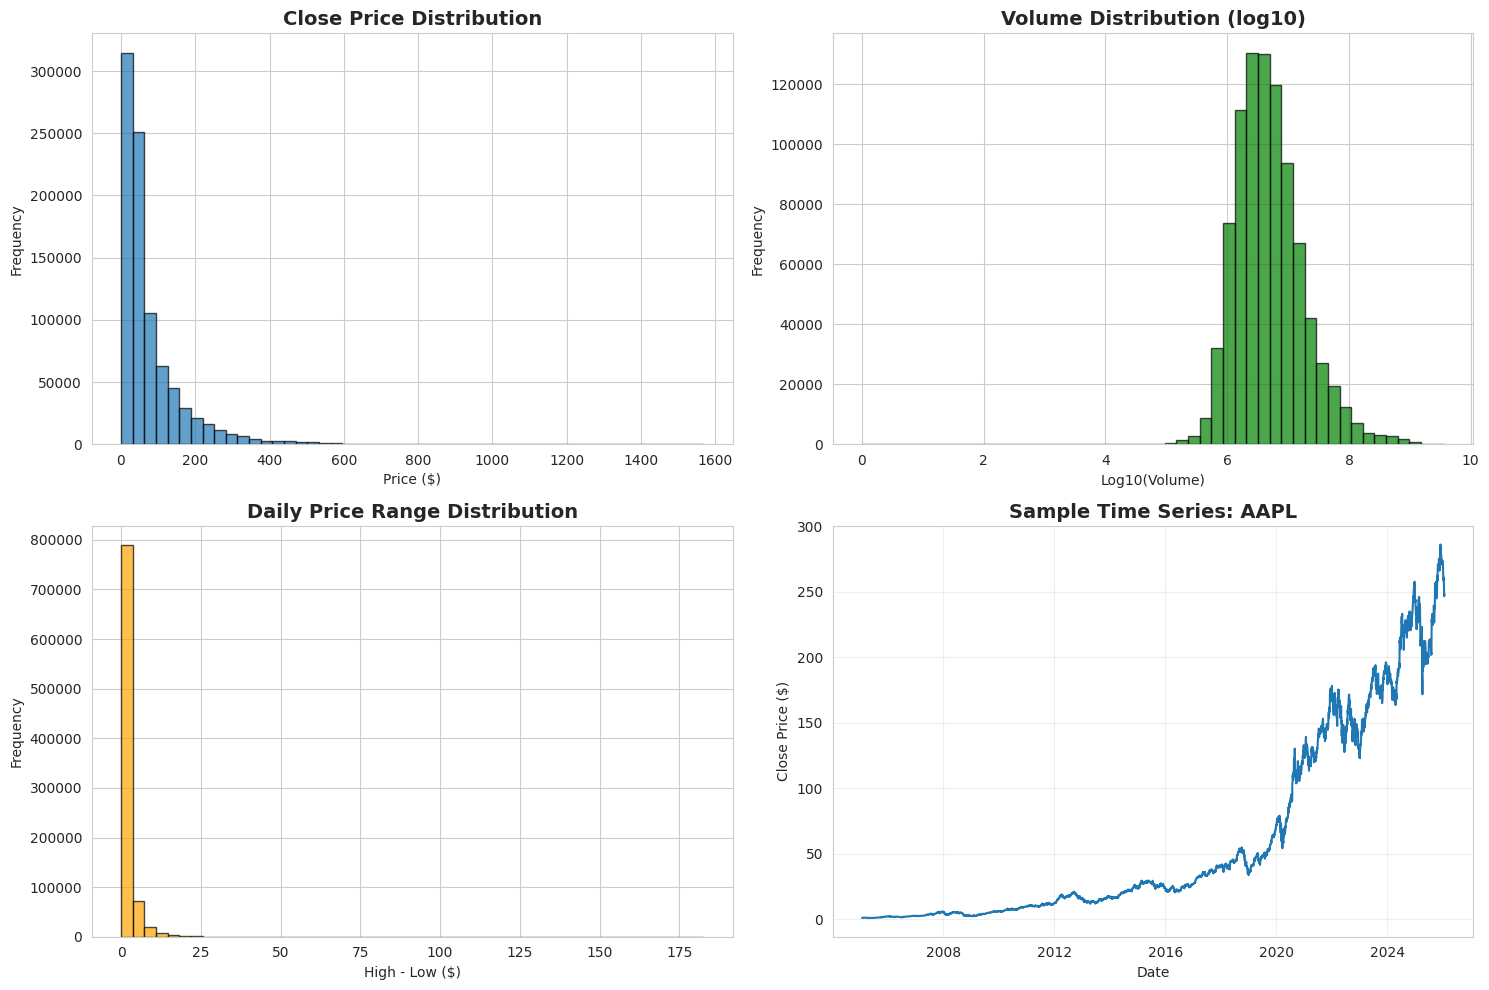

✓ Data quality visualization complete


In [6]:
# Visualize price distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Close price distribution
axes[0, 0].hist(df_raw['Close'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Close Price Distribution', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Price ($)')
axes[0, 0].set_ylabel('Frequency')

# Volume distribution (log scale)
axes[0, 1].hist(np.log10(df_raw['Volume'] + 1), bins=50, edgecolor='black', alpha=0.7, color='green')
axes[0, 1].set_title('Volume Distribution (log10)', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Log10(Volume)')
axes[0, 1].set_ylabel('Frequency')

# Price range (High - Low)
price_range = df_raw['High'] - df_raw['Low']
axes[1, 0].hist(price_range, bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1, 0].set_title('Daily Price Range Distribution', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('High - Low ($)')
axes[1, 0].set_ylabel('Frequency')

# Sample time series
if isinstance(df_raw.index, pd.MultiIndex):
    ticker_level = 'ticker' if 'ticker' in df_raw.index.names else df_raw.index.names[1]
    sample_ticker = df_raw.index.get_level_values(ticker_level)[0]
    sample_data = df_raw.xs(sample_ticker, level=ticker_level)
    axes[1, 1].plot(sample_data.index, sample_data['Close'], linewidth=1.5)
    axes[1, 1].set_title(f'Sample Time Series: {sample_ticker}', fontsize=14, fontweight='bold')
else:
    # If not MultiIndex, just plot first N rows
    axes[1, 1].plot(df_raw.index[:252], df_raw['Close'][:252], linewidth=1.5)
    axes[1, 1].set_title('Sample Time Series', fontsize=14, fontweight='bold')

axes[1, 1].set_xlabel('Date')
axes[1, 1].set_ylabel('Close Price ($)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"✓ Data quality visualization complete")


## 3. Feature Engineering

Calculate momentum, mean reversion, and volume features for ML prediction.

In [7]:
# Initialize feature engineer
feature_engineer = FeatureEngineer(
    momentum_periods=CONFIG['features']['momentum_periods'],
    ma_periods=CONFIG['features']['ma_periods']
)

print(" Calculating features...")
df_features = feature_engineer.calculate_all_features(df_raw)

print(f"\n✓ Feature engineering complete")
print(f"  Total features: {len([col for col in df_features.columns if col.startswith(('momentum_', 'ma_dist_', 'volume_'))])}")
print(f"  Dataset shape: {df_features.shape}")

2026-01-23 18:28:01.606 | INFO     | src.feature_engineering:__init__:45 - FeatureEngineer initialized with 6 momentum periods, 5 MA periods
2026-01-23 18:28:01.608 | INFO     | src.feature_engineering:calculate_all_features:228 - Starting feature calculation...


 Calculating features...


2026-01-23 18:28:03.259 | DEBUG    | src.feature_engineering:calculate_momentum_features:117 - Calculated 6 momentum features
2026-01-23 18:28:04.665 | DEBUG    | src.feature_engineering:calculate_mean_reversion_features:147 - Calculated 5 mean reversion features
2026-01-23 18:28:05.234 | DEBUG    | src.feature_engineering:calculate_volume_features:178 - Calculated volume features
2026-01-23 18:28:05.986 | DEBUG    | src.feature_engineering:calculate_volatility_features:210 - Calculated volatility features
2026-01-23 18:28:06.305 | INFO     | src.feature_engineering:calculate_all_features:246 - Feature calculation complete. Total features: 24



✓ Feature engineering complete
  Total features: 7
  Dataset shape: (892165, 24)


In [8]:
# Display feature columns
feature_cols = [col for col in df_features.columns if col.startswith(('momentum_', 'ma_dist_', 'volume_', 'volatility_'))]
print("Feature columns:")
for i, col in enumerate(feature_cols, 1):
    print(f"  {i:2d}. {col}")

Feature columns:
   1. momentum_5d
   2. momentum_10d
   3. momentum_20d
   4. momentum_60d
   5. momentum_126d
   6. momentum_252d
   7. volume_momentum_20d
   8. volatility_20d
   9. volatility_60d


### Feature Distribution Analysis

✓ Plotting 8 features


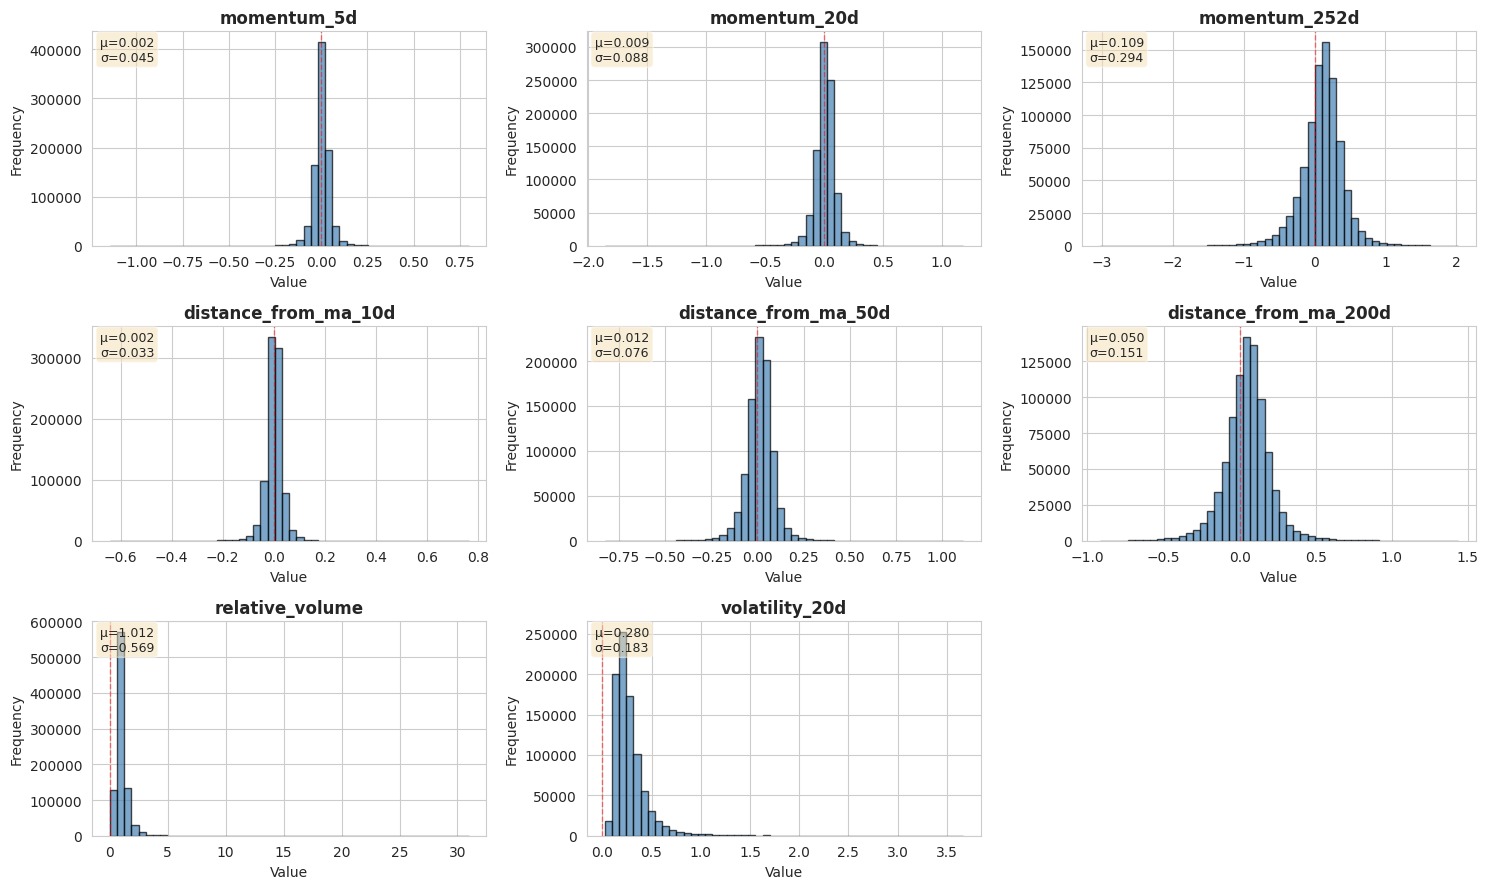

✓ Feature distribution analysis complete


In [9]:
# Select key features to visualize (using correct feature names from FeatureEngineer)
key_features_requested = [
    'momentum_5d', 'momentum_20d', 'momentum_252d',
    'distance_from_ma_10d', 'distance_from_ma_50d', 'distance_from_ma_200d',
    'relative_volume', 'volatility_20d'
]

# Filter to only features that actually exist
key_features = [f for f in key_features_requested if f in df_features.columns]

if not key_features:
    print("None of the requested features found in dataset")
    print(f"Available feature columns: {[col for col in df_features.columns if col.startswith(('momentum_', 'distance_from_ma_', 'relative_volume', 'volatility_'))]}")
else:
    # Report missing features
    missing_features = [f for f in key_features_requested if f not in df_features.columns]
    if missing_features:
        print(f"Missing features (will skip): {missing_features}")
    
    print(f"✓ Plotting {len(key_features)} features")
    
    # Create subplot grid based on available features
    n_features = len(key_features)
    n_cols = 3
    n_rows = (n_features + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 3))
    
    # Handle single row case
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    axes = axes.flatten()
    
    for idx, feature in enumerate(key_features):
        data = df_features[feature].dropna()
        
        if len(data) == 0:
            axes[idx].text(0.5, 0.5, f'No data for\n{feature}', 
                          ha='center', va='center', fontsize=12)
            axes[idx].set_title(feature, fontsize=12, fontweight='bold')
        else:
            axes[idx].hist(data, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
            axes[idx].set_title(feature, fontsize=12, fontweight='bold')
            axes[idx].set_xlabel('Value')
            axes[idx].set_ylabel('Frequency')
            axes[idx].axvline(0, color='red', linestyle='--', alpha=0.5, linewidth=1)
            
            # Add stats
            axes[idx].text(0.02, 0.98, f'μ={data.mean():.3f}\nσ={data.std():.3f}',
                          transform=axes[idx].transAxes, fontsize=9,
                          verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # Hide extra subplots
    for idx in range(n_features, len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print("✓ Feature distribution analysis complete")


### Feature Correlation Analysis

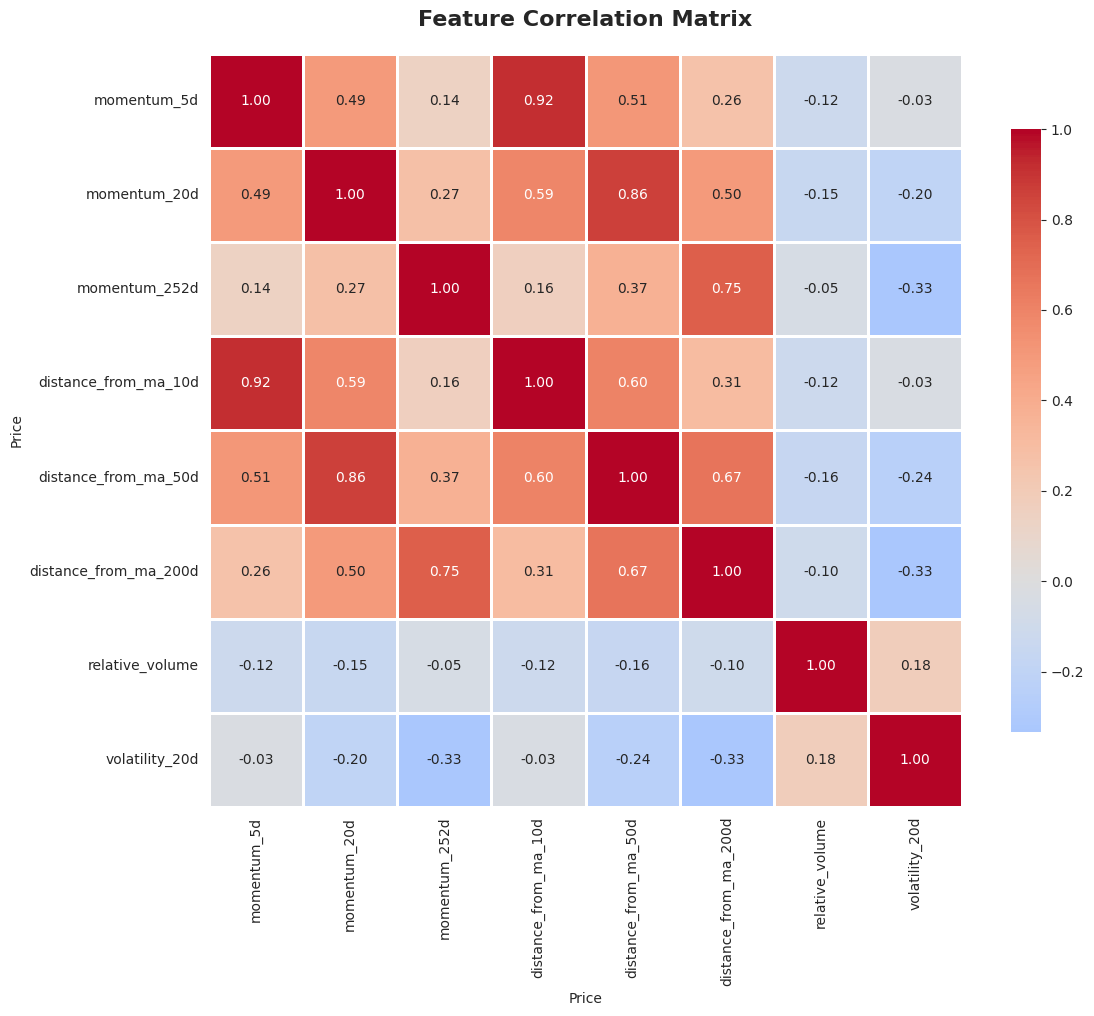

✓ Feature correlation analysis complete


In [10]:
# Calculate correlation matrix
# Use only features that exist
available_key_features = [f for f in key_features if f in df_features.columns]

if len(available_key_features) < 2:
    print("Need at least 2 features for correlation analysis")
    print(f"Available features: {available_key_features}")
else:
    feature_data = df_features[available_key_features].dropna()
    
    if len(feature_data) == 0:
        print("No data available after dropping NaN values")
    else:
        corr_matrix = feature_data.corr()
        
        # Plot heatmap
        plt.figure(figsize=(12, 10))
        sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
                    square=True, linewidths=1, cbar_kws={"shrink": 0.8})
        plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold', pad=20)
        plt.tight_layout()
        plt.show()
        
        print("✓ Feature correlation analysis complete")


## 4. Prepare ML Dataset

Create features (X) and target variable (y) for model training.

In [11]:
# Prepare ML dataset
print("Preparing ML dataset...")
X, y, feature_names = feature_engineer.prepare_ml_dataset(df_features)

print(f"\n✓ ML dataset ready")
print(f"  Features shape: {X.shape}")
print(f"  Target shape: {y.shape}")
print(f"  Feature names: {len(feature_names)}")
print(f"\nTarget variable (3-day return) statistics:")
print(f"  Mean: {y.mean():.4f}")
print(f"  Std: {y.std():.4f}")
print(f"  Min: {y.min():.4f}")
print(f"  Max: {y.max():.4f}")

2026-01-23 18:28:08.720 | INFO     | src.feature_engineering:prepare_ml_dataset:309 - Dropped NaN values. Remaining samples: 847030
2026-01-23 18:28:08.721 | INFO     | src.feature_engineering:prepare_ml_dataset:311 - ML dataset prepared: 847030 samples, 17 features, target: forward_return_3d


Preparing ML dataset...

✓ ML dataset ready
  Features shape: (847030, 17)
  Target shape: (847030,)
  Feature names: 17

Target variable (3-day return) statistics:
  Mean: 0.0013
  Std: 0.0356
  Min: -0.9675
  Max: 0.6399


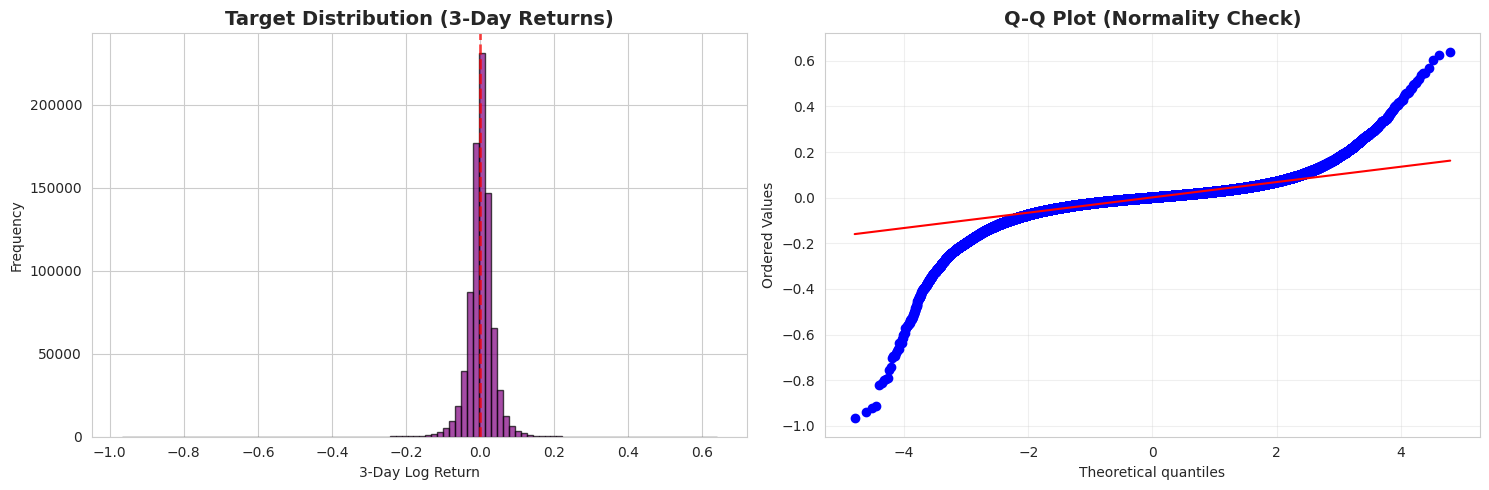


Distribution statistics:
  Skewness: -0.6837
  Kurtosis: 19.5103


In [12]:
# Plot target distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram
axes[0].hist(y, bins=100, edgecolor='black', alpha=0.7, color='purple')
axes[0].set_title('Target Distribution (3-Day Returns)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('3-Day Log Return')
axes[0].set_ylabel('Frequency')
axes[0].axvline(0, color='red', linestyle='--', linewidth=2, alpha=0.7)

# QQ plot
from scipy import stats
stats.probplot(y, dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot (Normality Check)', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate skewness and kurtosis
print(f"\nDistribution statistics:")
print(f"  Skewness: {stats.skew(y):.4f}")
print(f"  Kurtosis: {stats.kurtosis(y):.4f}")

## 5. Train/Test Split

Split data into training and testing sets using temporal ordering.

In [13]:
# Calculate split point
split_idx = int(len(X) * (1 - CONFIG['models']['validation_split']))

X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print(f"Dataset split:")
print(f"  Training set: {len(X_train):,} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"  Test set: {len(X_test):,} samples ({len(X_test)/len(X)*100:.1f}%)")
print(f"\nTarget distribution:")
print(f"  Train mean: {y_train.mean():.4f}, std: {y_train.std():.4f}")
print(f"  Test mean: {y_test.mean():.4f}, std: {y_test.std():.4f}")

Dataset split:
  Training set: 677,624 samples (80.0%)
  Test set: 169,406 samples (20.0%)

Target distribution:
  Train mean: 0.0014, std: 0.0358
  Test mean: 0.0009, std: 0.0349


## 6. Model Training

Train multiple ML models and compare their performance.

In [14]:
# Store results
model_results = {}

print("Training models...\n")
print("="*80)

for model_type in CONFIG['models']['types_to_test']:
    print(f"\nTraining {model_type.upper()} model...")
    print("-"*80)
    
    # Initialize trainer (feature_names not needed in init)
    trainer = ModelTrainer(model_type=model_type)
    
    # Train (X_val and y_val are the test set)
    metrics = trainer.train(X_train, y_train, X_test, y_test)
    
    # Convert metric names to match expected format
    formatted_metrics = {
        'train_r2': metrics['train_r2'],
        'train_rmse': np.sqrt(metrics['train_mse']),
        'test_r2': metrics.get('val_r2', 0.0),
        'test_rmse': np.sqrt(metrics.get('val_mse', 1.0)),
        'test_mae': metrics.get('val_mae', 0.0)
    }
    
    # Store results
    model_results[model_type] = {
        'trainer': trainer,
        'metrics': formatted_metrics
    }
    
    # Print metrics
    print(f"\n  Training Metrics:")
    print(f"    R² Score: {formatted_metrics['train_r2']:.4f}")
    print(f"    RMSE: {formatted_metrics['train_rmse']:.6f}")
    
    print(f"\n  Test Metrics:")
    print(f"    R² Score: {formatted_metrics['test_r2']:.4f}")
    print(f"    RMSE: {formatted_metrics['test_rmse']:.6f}")
    print(f"    MAE: {formatted_metrics['test_mae']:.6f}")
    
    print(f"\n  ✓ {model_type} training complete")

print("\n" + "="*80)
print("✓ All models trained successfully")

2026-01-23 18:28:10.772 | INFO     | src.model_trainer:__init__:64 - ModelTrainer initialized: ridge, rolling window: 10 years, retrain frequency: 365 days
2026-01-23 18:28:10.772 | INFO     | src.model_trainer:train:159 - Training ridge model on 677624 samples...


Training models...


Training RIDGE model...
--------------------------------------------------------------------------------


2026-01-23 18:28:11.180 | INFO     | src.model_trainer:train:189 - Training complete. Metrics: {'train_mse': 0.0012745579305397728, 'train_mae': 0.023383236565966692, 'train_r2': 0.004851702706599181, 'val_mse': 0.0012175846441235378, 'val_mae': 0.02437250601978406, 'val_r2': 0.0008676882630855864}
2026-01-23 18:28:11.183 | INFO     | src.model_trainer:__init__:64 - ModelTrainer initialized: random_forest, rolling window: 10 years, retrain frequency: 365 days
2026-01-23 18:28:11.184 | INFO     | src.model_trainer:train:159 - Training random_forest model on 677624 samples...



  Training Metrics:
    R² Score: 0.0049
    RMSE: 0.035701

  Test Metrics:
    R² Score: 0.0009
    RMSE: 0.034894
    MAE: 0.024373

  ✓ ridge training complete

Training RANDOM_FOREST model...
--------------------------------------------------------------------------------


2026-01-23 18:32:57.266 | INFO     | src.model_trainer:train:189 - Training complete. Metrics: {'train_mse': 0.0012341221602035419, 'train_mae': 0.023215933254937458, 'train_r2': 0.03642311035756862, 'val_mse': 0.0012194154278042765, 'val_mae': 0.02435268758604098, 'val_r2': -0.0006346262906129496}
2026-01-23 18:32:57.267 | INFO     | src.model_trainer:__init__:64 - ModelTrainer initialized: xgboost, rolling window: 10 years, retrain frequency: 365 days
2026-01-23 18:32:57.268 | INFO     | src.model_trainer:train:159 - Training xgboost model on 677624 samples...



  Training Metrics:
    R² Score: 0.0364
    RMSE: 0.035130

  Test Metrics:
    R² Score: -0.0006
    RMSE: 0.034920
    MAE: 0.024353

  ✓ random_forest training complete

Training XGBOOST model...
--------------------------------------------------------------------------------


2026-01-23 18:33:00.630 | INFO     | src.model_trainer:train:189 - Training complete. Metrics: {'train_mse': 0.0011866748076989264, 'train_mae': 0.02301630822797534, 'train_r2': 0.07346901539230599, 'val_mse': 0.0012267397270507088, 'val_mae': 0.02440668826874901, 'val_r2': -0.006644840096494908}
2026-01-23 18:33:00.632 | INFO     | src.model_trainer:__init__:64 - ModelTrainer initialized: lightgbm, rolling window: 10 years, retrain frequency: 365 days
2026-01-23 18:33:00.632 | INFO     | src.model_trainer:train:159 - Training lightgbm model on 677624 samples...



  Training Metrics:
    R² Score: 0.0735
    RMSE: 0.034448

  Test Metrics:
    R² Score: -0.0066
    RMSE: 0.035025
    MAE: 0.024407

  ✓ xgboost training complete

Training LIGHTGBM model...
--------------------------------------------------------------------------------


2026-01-23 18:33:03.045 | INFO     | src.model_trainer:train:189 - Training complete. Metrics: {'train_mse': 0.0011954812944091281, 'train_mae': 0.02302698811140512, 'train_r2': 0.06659309391019441, 'val_mse': 0.001224789896387112, 'val_mae': 0.024401977686174647, 'val_r2': -0.005044837314086559}



  Training Metrics:
    R² Score: 0.0666
    RMSE: 0.034576

  Test Metrics:
    R² Score: -0.0050
    RMSE: 0.034997
    MAE: 0.024402

  ✓ lightgbm training complete

✓ All models trained successfully


### Model Performance Comparison

In [28]:
# Compare model performance
comparison_df = pd.DataFrame({
    'Model': list(model_results.keys()),
    'Train R²': [model_results[m]['metrics']['train_r2'] for m in model_results],
    'Test R²': [model_results[m]['metrics']['test_r2'] for m in model_results],
    'Test RMSE': [model_results[m]['metrics']['test_rmse'] for m in model_results],
    'Test MAE': [model_results[m]['metrics']['test_mae'] for m in model_results],
})

# Calculate overfit metric
comparison_df['Overfit Gap'] = comparison_df['Train R²'] - comparison_df['Test R²']

print("MODEL PERFORMANCE COMPARISON")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80)

# Find best model
best_model_name = comparison_df.loc[comparison_df['Test R²'].idxmax(), 'Model']
print(f"\nBest model (by Test R²): {best_model_name.upper()}")

MODEL PERFORMANCE COMPARISON
        Model  Train R²   Test R²  Test RMSE  Test MAE  Overfit Gap
        ridge  0.004852  0.000868   0.034894  0.024373     0.003984
random_forest  0.036423 -0.000635   0.034920  0.024353     0.037058
      xgboost  0.073469 -0.006645   0.035025  0.024407     0.080114
     lightgbm  0.066593 -0.005045   0.034997  0.024402     0.071638

Best model (by Test R²): RIDGE


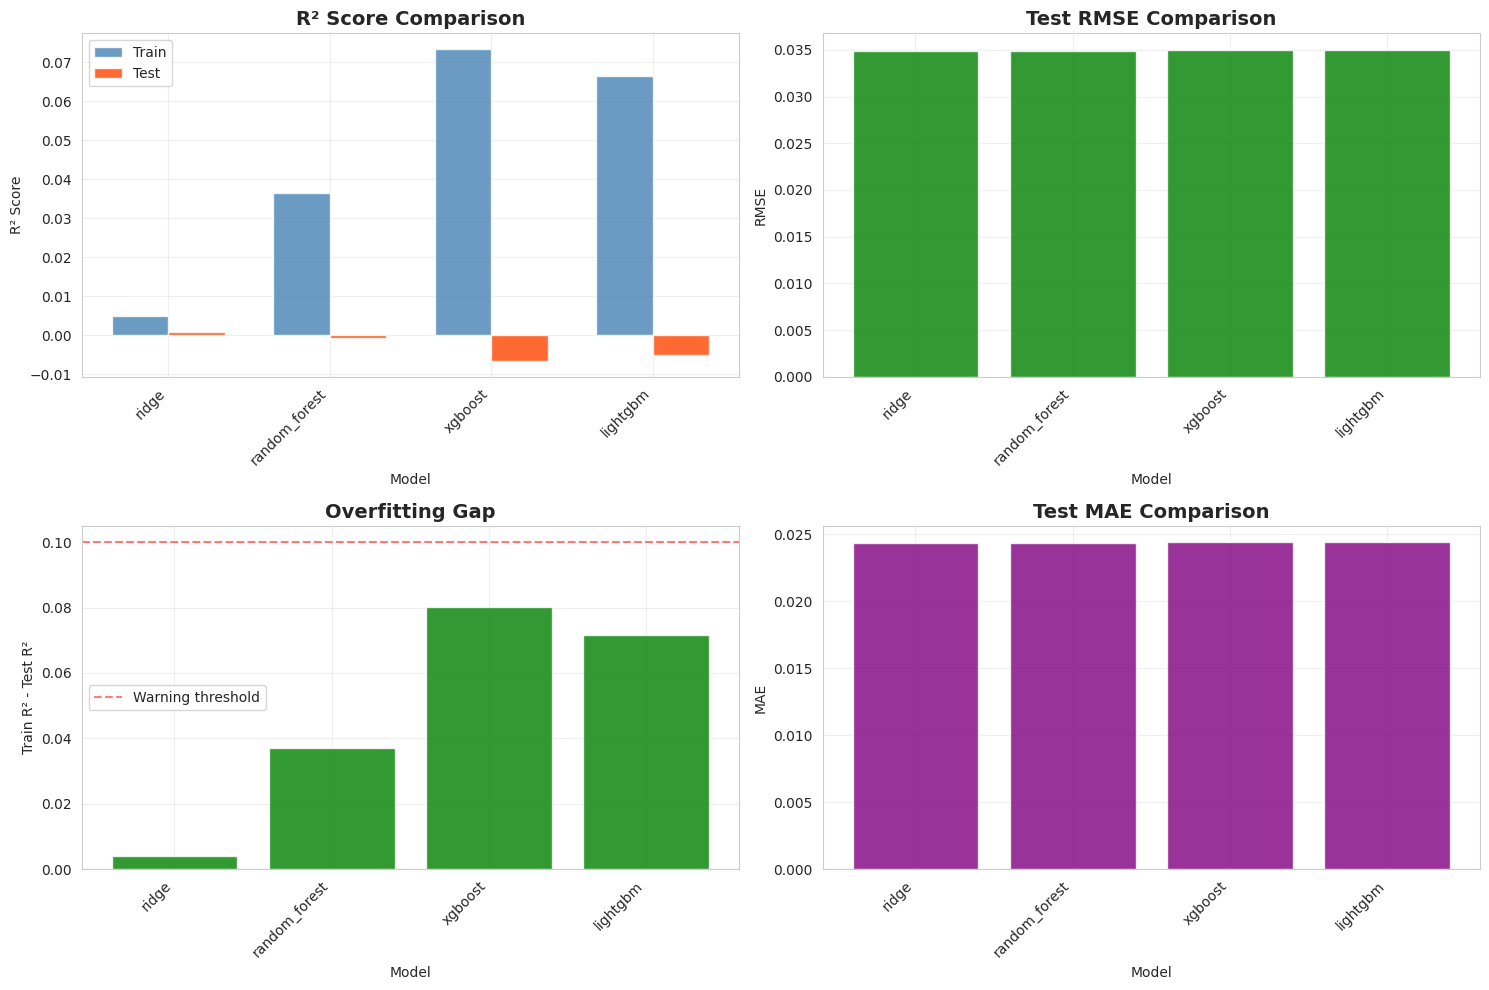

✓ Model performance visualization complete


In [16]:
# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# R² Comparison
ax = axes[0, 0]
x_pos = np.arange(len(comparison_df))
width = 0.35
ax.bar(x_pos - width/2, comparison_df['Train R²'], width, label='Train', alpha=0.8, color='steelblue')
ax.bar(x_pos + width/2, comparison_df['Test R²'], width, label='Test', alpha=0.8, color='orangered')
ax.set_xlabel('Model')
ax.set_ylabel('R² Score')
ax.set_title('R² Score Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3)

# RMSE Comparison
ax = axes[0, 1]
ax.bar(comparison_df['Model'], comparison_df['Test RMSE'], alpha=0.8, color='green')
ax.set_xlabel('Model')
ax.set_ylabel('RMSE')
ax.set_title('Test RMSE Comparison', fontsize=14, fontweight='bold')
ax.set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
ax.grid(True, alpha=0.3)

# Overfit Gap
ax = axes[1, 0]
colors = ['red' if x > 0.1 else 'green' for x in comparison_df['Overfit Gap']]
ax.bar(comparison_df['Model'], comparison_df['Overfit Gap'], alpha=0.8, color=colors)
ax.set_xlabel('Model')
ax.set_ylabel('Train R² - Test R²')
ax.set_title('Overfitting Gap', fontsize=14, fontweight='bold')
ax.set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
ax.axhline(0.1, color='red', linestyle='--', alpha=0.5, label='Warning threshold')
ax.legend()
ax.grid(True, alpha=0.3)

# MAE Comparison
ax = axes[1, 1]
ax.bar(comparison_df['Model'], comparison_df['Test MAE'], alpha=0.8, color='purple')
ax.set_xlabel('Model')
ax.set_ylabel('MAE')
ax.set_title('Test MAE Comparison', fontsize=14, fontweight='bold')
ax.set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Model performance visualization complete")

## 7. Feature Importance Analysis

Analyze which features contribute most to predictions.

TOP 20 FEATURES (RIDGE)
              feature  importance
distance_from_ma_100d    0.004668
         momentum_60d    0.004340
 distance_from_ma_20d    0.002607
         momentum_10d    0.002365
       volatility_60d    0.001720
       volatility_20d    0.001418
 distance_from_ma_10d    0.001286
        momentum_126d    0.000816
distance_from_ma_200d    0.000638
          momentum_5d    0.000541
      relative_volume    0.000390
        momentum_252d    0.000359
  volume_momentum_20d    0.000221
        hl_range_ma20    0.000204
         momentum_20d    0.000069
             hl_range    0.000013
 distance_from_ma_50d    0.000013


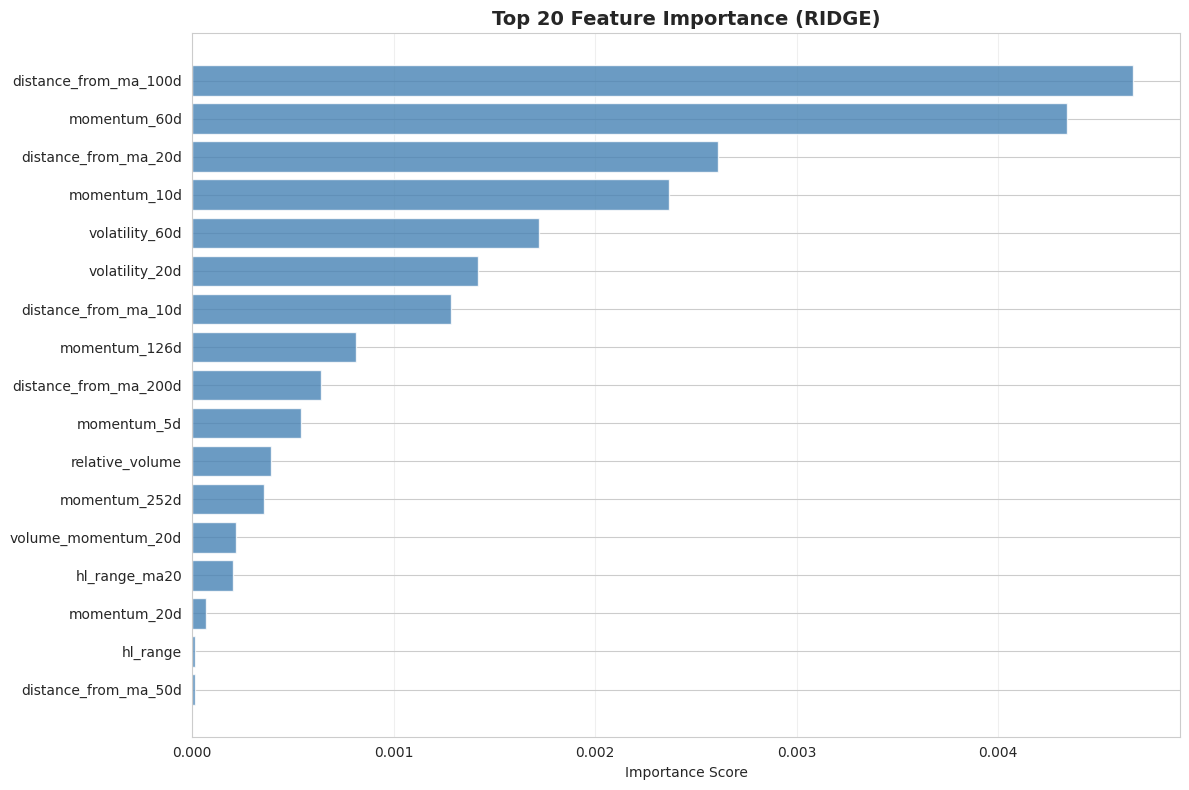


✓ Feature importance analysis complete


In [17]:
# Get feature importance from best model
best_trainer = model_results[best_model_name]['trainer']
feature_importance = best_trainer.get_feature_importance(feature_names)

if feature_importance is not None and len(feature_importance) > 0:
    # Sort by importance
    feature_importance = feature_importance.sort_values('importance', ascending=False)
    
    print(f"TOP 20 FEATURES ({best_model_name.upper()})")
    print("="*80)
    print(feature_importance.head(20).to_string(index=False))
    print("="*80)
    
    # Plot top features
    top_n = 20
    top_features = feature_importance.head(top_n)
    
    plt.figure(figsize=(12, 8))
    plt.barh(range(len(top_features)), top_features['importance'], alpha=0.8, color='steelblue')
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Importance Score')
    plt.title(f'Top {top_n} Feature Importance ({best_model_name.upper()})', 
              fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()
    
    print(f"\n✓ Feature importance analysis complete")
else:
    print(f" Feature importance not available for {best_model_name}")

## 8. Prediction Analysis

Analyze model predictions vs actual returns.

In [18]:
# Get predictions for best model
best_trainer = model_results[best_model_name]['trainer']
y_pred_train = best_trainer.predict(X_train)
y_pred_test = best_trainer.predict(X_test)

print(f"Predictions generated using {best_model_name.upper()} model")
print(f"  Training predictions: {len(y_pred_train):,}")
print(f"  Test predictions: {len(y_pred_test):,}")

Predictions generated using RIDGE model
  Training predictions: 677,624
  Test predictions: 169,406


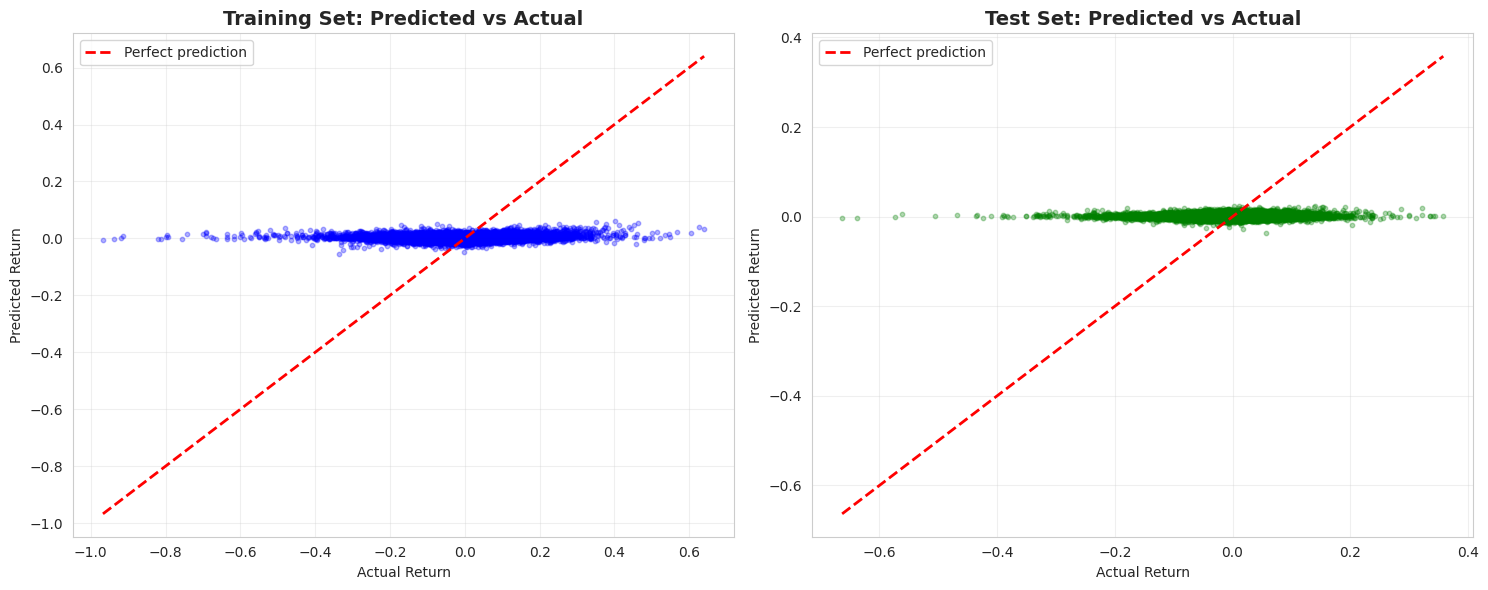

✓ Prediction scatter plots complete


In [19]:
# Prediction vs Actual scatter plots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Training set
ax = axes[0]
ax.scatter(y_train, y_pred_train, alpha=0.3, s=10, color='blue')
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 
        'r--', linewidth=2, label='Perfect prediction')
ax.set_xlabel('Actual Return')
ax.set_ylabel('Predicted Return')
ax.set_title('Training Set: Predicted vs Actual', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Test set
ax = axes[1]
ax.scatter(y_test, y_pred_test, alpha=0.3, s=10, color='green')
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
        'r--', linewidth=2, label='Perfect prediction')
ax.set_xlabel('Actual Return')
ax.set_ylabel('Predicted Return')
ax.set_title('Test Set: Predicted vs Actual', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Prediction scatter plots complete")

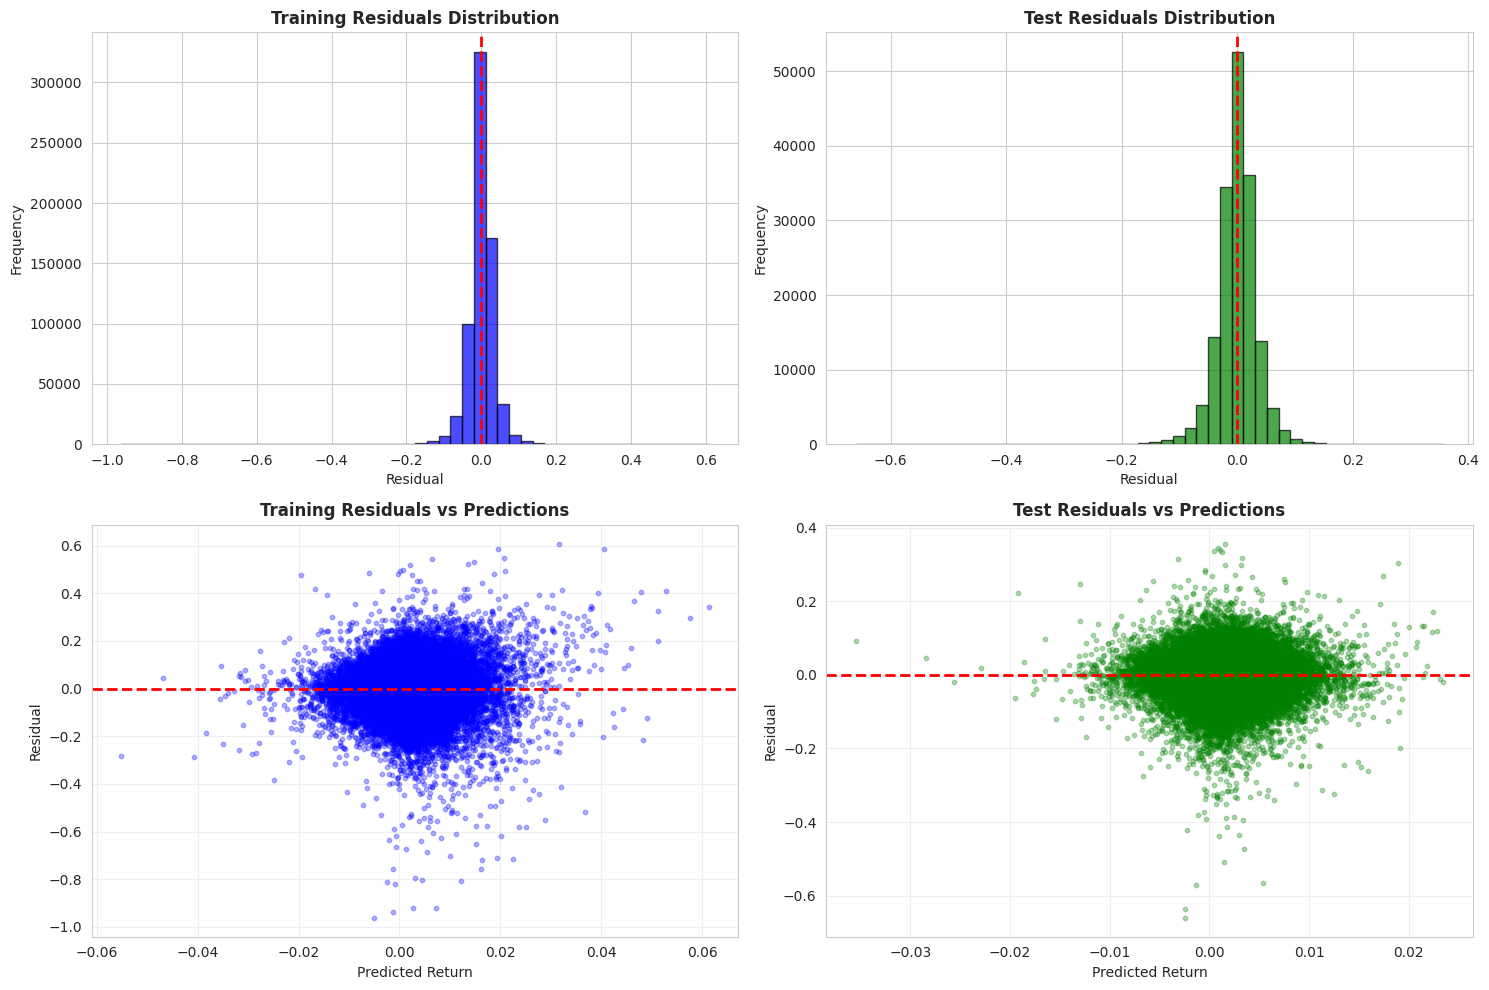

Residual statistics:
  Training: mean=0.000000, std=0.035701
  Test: mean=-0.000555, std=0.034890


In [20]:
# Residual analysis
residuals_train = y_train - y_pred_train
residuals_test = y_test - y_pred_test

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Train residuals histogram
axes[0, 0].hist(residuals_train, bins=50, edgecolor='black', alpha=0.7, color='blue')
axes[0, 0].set_title('Training Residuals Distribution', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Residual')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(0, color='red', linestyle='--', linewidth=2)

# Test residuals histogram
axes[0, 1].hist(residuals_test, bins=50, edgecolor='black', alpha=0.7, color='green')
axes[0, 1].set_title('Test Residuals Distribution', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Residual')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].axvline(0, color='red', linestyle='--', linewidth=2)

# Train residuals vs predictions
axes[1, 0].scatter(y_pred_train, residuals_train, alpha=0.3, s=10, color='blue')
axes[1, 0].axhline(0, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_title('Training Residuals vs Predictions', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Predicted Return')
axes[1, 0].set_ylabel('Residual')
axes[1, 0].grid(True, alpha=0.3)

# Test residuals vs predictions
axes[1, 1].scatter(y_pred_test, residuals_test, alpha=0.3, s=10, color='green')
axes[1, 1].axhline(0, color='red', linestyle='--', linewidth=2)
axes[1, 1].set_title('Test Residuals vs Predictions', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Predicted Return')
axes[1, 1].set_ylabel('Residual')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Residual statistics:")
print(f"  Training: mean={residuals_train.mean():.6f}, std={residuals_train.std():.6f}")
print(f"  Test: mean={residuals_test.mean():.6f}, std={residuals_test.std():.6f}")

## 9. Portfolio Construction Simulation

Simulate portfolio construction using predictions from the best model.

In [21]:
# Initialize portfolio builder
portfolio_builder = PortfolioBuilder(
    n_long=CONFIG['portfolio']['n_long'],
    n_short=CONFIG['portfolio']['n_short'],
    max_position_size=CONFIG['portfolio']['max_position_size']
)

print(f"  Portfolio Configuration:")
print(f"  Long positions: {CONFIG['portfolio']['n_long']}")
print(f"  Short positions: {CONFIG['portfolio']['n_short']}")
print(f"  Max position size: {CONFIG['portfolio']['max_position_size']*100}%")
print(f"  Holding period: {CONFIG['portfolio']['holding_days']} days")

2026-01-23 18:33:10.446 | INFO     | src.portfolio_builder:__init__:51 - PortfolioBuilder initialized: 20 long / 20 short positions, max position size: 4.0%, 3 staggered portfolios


  Portfolio Configuration:
  Long positions: 20
  Short positions: 20
  Max position size: 4.0%
  Holding period: 3 days


In [22]:
# Prepare data for portfolio simulation
# We need predictions with corresponding tickers and dates

# Reconstruct the date and ticker information
# Note: This assumes the indices align with df_features after dropna
df_ml_ready = df_features.dropna()
df_ml_ready = df_ml_ready[df_ml_ready['forward_return_3d'].notna()]

# Get test set indices
test_start_idx = split_idx
df_test = df_ml_ready.iloc[test_start_idx:]

# Create predictions dataframe
predictions_df = pd.DataFrame({
    'predicted_return': y_pred_test
}, index=df_test.index)

predictions_df['actual_return'] = y_test

print(f"Predictions prepared: {len(predictions_df):,} samples")

# Handle index reporting based on structure
if isinstance(predictions_df.index, pd.MultiIndex):
    date_level = 'date' if 'date' in predictions_df.index.names else predictions_df.index.names[0]
    ticker_level = 'ticker' if 'ticker' in predictions_df.index.names else predictions_df.index.names[1]
    
    date_min = predictions_df.index.get_level_values(date_level).min()
    date_max = predictions_df.index.get_level_values(date_level).max()
    n_tickers = predictions_df.index.get_level_values(ticker_level).nunique()
    
    if hasattr(date_min, 'date'):
        print(f"Date range: {date_min.date()} to {date_max.date()}")
    else:
        print(f"Date range: {date_min} to {date_max}")
    print(f"Tickers: {n_tickers}")
else:
    print(f"Index type: {type(predictions_df.index).__name__}")


Predictions prepared: 169,406 samples
Date range: 2022-04-08 to 2026-01-21
Tickers: 177


In [23]:
# Simulate portfolio construction for sample dates
if isinstance(predictions_df.index, pd.MultiIndex):
    date_level = 'date' if 'date' in predictions_df.index.names else predictions_df.index.names[0]
    ticker_level = 'ticker' if 'ticker' in predictions_df.index.names else predictions_df.index.names[1]
    
    sample_dates = predictions_df.index.get_level_values(date_level).unique()[::20]  # Every 20 days
    print(f"Simulating portfolio construction for {len(sample_dates)} dates")
    
    portfolios = []
    skip_reasons = {'insufficient_stocks': 0, 'error': 0, 'empty_portfolio': 0}
    
    for i, date in enumerate(sample_dates):
        # Get predictions for this date
        try:
            date_preds = predictions_df.xs(date, level=date_level)
            
            if len(date_preds) < (CONFIG['portfolio']['n_long'] + CONFIG['portfolio']['n_short']):
                skip_reasons['insufficient_stocks'] += 1
                if i < 3:  # Show first few
                    print(f"  Date {date}: Only {len(date_preds)} stocks (need {CONFIG['portfolio']['n_long'] + CONFIG['portfolio']['n_short']})")
                continue
            
            # Convert to Series for build_portfolio (expects ticker index)
            pred_series = date_preds['predicted_return']
            
            # Get prices for this date
            date_data = df_test.xs(date, level=date_level)
            prices_series = date_data['Close']
            
            # Build portfolio
            portfolio_df = portfolio_builder.build_portfolio(
                predictions=pred_series,
                prices=prices_series,
                date=date
            )
            
            if portfolio_df is not None and not portfolio_df.empty:
                portfolios.append(portfolio_df)
                if len(portfolios) <= 3:  # Show first few successes
                    print(f"  ✓ Date {date}: Built portfolio with {len(portfolio_df)} positions")
            else:
                skip_reasons['empty_portfolio'] += 1
                if i < 3:  # Show first few
                    print(f"  Date {date}: Portfolio builder returned empty/None")
                    
        except Exception as e:
            skip_reasons['error'] += 1
            if i < 3:  # Show first few errors
                print(f"  Date {date}: Error - {type(e).__name__}: {str(e)}")
            continue
    
    print(f"\n✓ Constructed {len(portfolios)} portfolios")
    print(f"\nSkip reasons:")
    print(f"  Insufficient stocks: {skip_reasons['insufficient_stocks']}")
    print(f"  Empty portfolio returned: {skip_reasons['empty_portfolio']}")
    print(f"  Errors: {skip_reasons['error']}")
else:
    print("   Portfolio simulation requires MultiIndex data structure")
    print("   Skipping portfolio simulation section")
    portfolios = []


2026-01-23 18:33:10.730 | INFO     | src.portfolio_builder:build_portfolio:216 - Building portfolio for 2022-04-08
2026-01-23 18:33:10.733 | INFO     | src.portfolio_builder:select_long_short:118 - Selected 20 long and 20 short positions
2026-01-23 18:33:10.736 | INFO     | src.portfolio_builder:build_portfolio:243 - Portfolio built: Long $165,586, Short $164,903, Net $683, Gross $330,489
2026-01-23 18:33:10.737 | INFO     | src.portfolio_builder:build_portfolio:216 - Building portfolio for 2022-05-09
2026-01-23 18:33:10.740 | INFO     | src.portfolio_builder:select_long_short:118 - Selected 20 long and 20 short positions
2026-01-23 18:33:10.745 | INFO     | src.portfolio_builder:build_portfolio:243 - Portfolio built: Long $165,447, Short $165,434, Net $13, Gross $330,881
2026-01-23 18:33:10.747 | INFO     | src.portfolio_builder:build_portfolio:216 - Building portfolio for 2022-06-07
2026-01-23 18:33:10.749 | INFO     | src.portfolio_builder:select_long_short:118 - Selected 20 long an

Simulating portfolio construction for 48 dates
  ✓ Date 2022-04-08 00:00:00: Built portfolio with 40 positions
  ✓ Date 2022-05-09 00:00:00: Built portfolio with 40 positions
  ✓ Date 2022-06-07 00:00:00: Built portfolio with 40 positions


2026-01-23 18:33:10.904 | INFO     | src.portfolio_builder:select_long_short:118 - Selected 20 long and 20 short positions
2026-01-23 18:33:10.909 | INFO     | src.portfolio_builder:build_portfolio:243 - Portfolio built: Long $165,433, Short $165,198, Net $235, Gross $330,631
2026-01-23 18:33:10.912 | INFO     | src.portfolio_builder:build_portfolio:216 - Building portfolio for 2023-08-17
2026-01-23 18:33:10.916 | INFO     | src.portfolio_builder:select_long_short:118 - Selected 20 long and 20 short positions
2026-01-23 18:33:10.919 | INFO     | src.portfolio_builder:build_portfolio:243 - Portfolio built: Long $165,429, Short $165,692, Net $-264, Gross $331,121
2026-01-23 18:33:10.921 | INFO     | src.portfolio_builder:build_portfolio:216 - Building portfolio for 2023-09-15
2026-01-23 18:33:10.924 | INFO     | src.portfolio_builder:select_long_short:118 - Selected 20 long and 20 short positions
2026-01-23 18:33:10.929 | INFO     | src.portfolio_builder:build_portfolio:243 - Portfolio b


✓ Constructed 48 portfolios

Skip reasons:
  Insufficient stocks: 0
  Empty portfolio returned: 0
  Errors: 0


PORTFOLIO STATISTICS
                      date  n_long  n_short  long_weight  short_weight  \
count                   48    48.0     48.0    48.000000     48.000000   
mean   2024-02-22 18:30:00    20.0     20.0     0.165266      0.164901   
min    2022-04-08 00:00:00    20.0     20.0     0.164125      0.162800   
25%    2023-03-17 00:00:00    20.0     20.0     0.165083      0.164536   
50%    2024-02-22 12:00:00    20.0     20.0     0.165316      0.164974   
75%    2025-01-31 18:00:00    20.0     20.0     0.165479      0.165378   
max    2026-01-08 00:00:00    20.0     20.0     0.166104      0.166008   
std                    NaN     0.0      0.0     0.000439      0.000630   

       net_exposure  gross_exposure  
count     48.000000       48.000000  
mean       0.000365        0.330167  
min       -0.000841        0.328230  
25%       -0.000137        0.329659  
50%        0.000349        0.330295  
75%        0.000744        0.330680  
max        0.003304        0.331722  
std     

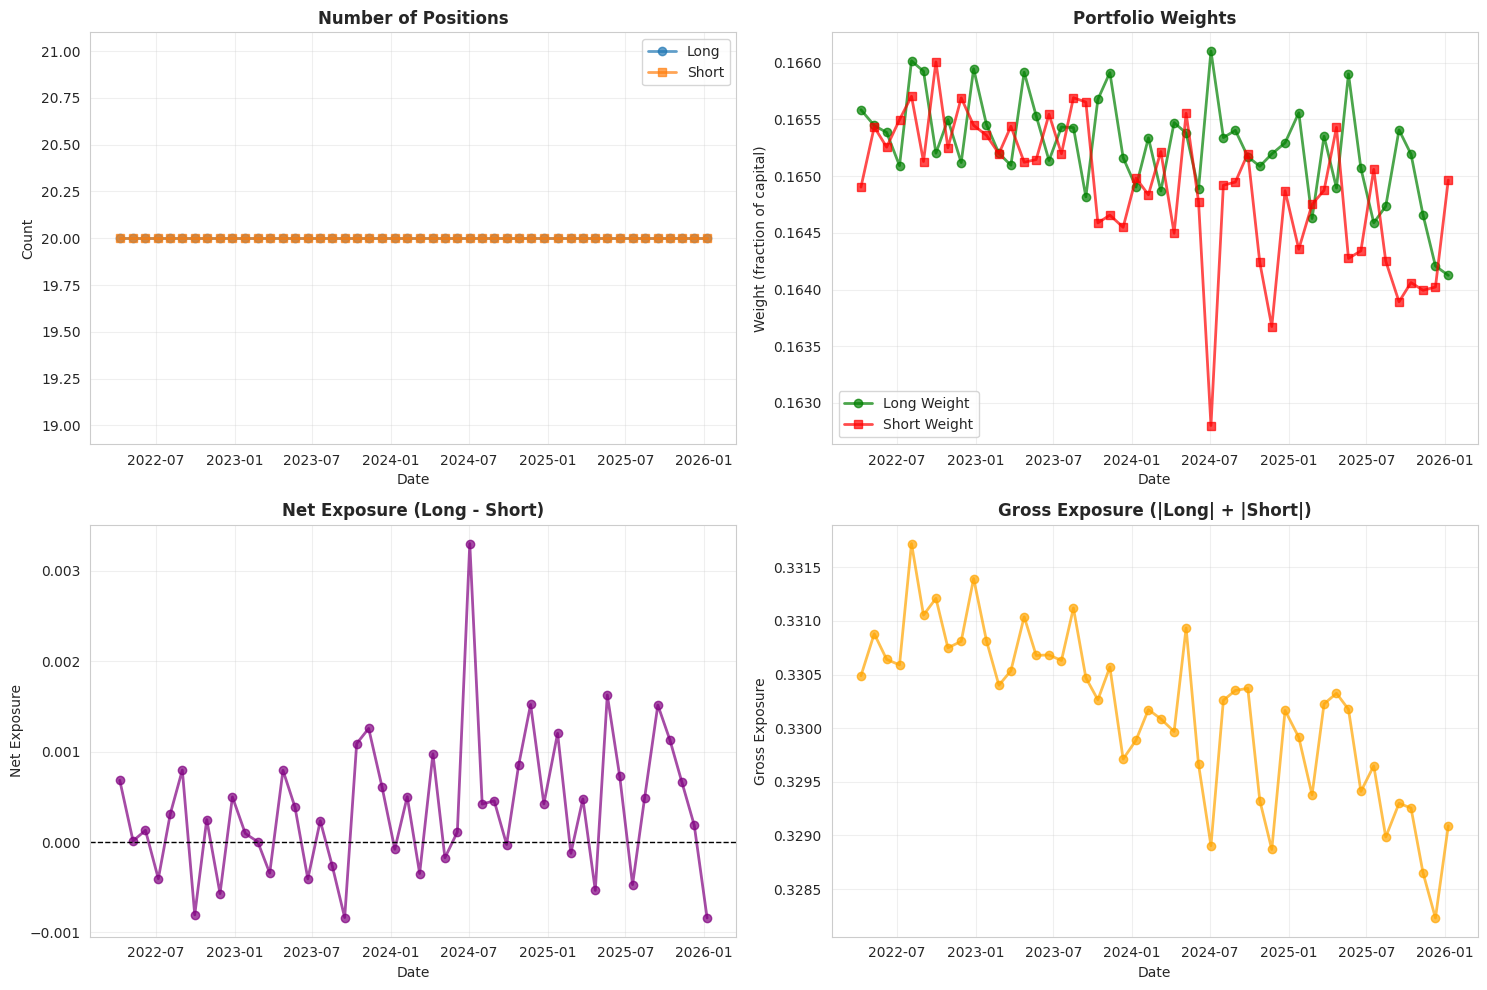


✓ Portfolio analysis complete


In [24]:
# Analyze portfolio characteristics
if portfolios:
    # Combine all portfolio DataFrames
    all_portfolios = pd.concat(portfolios, ignore_index=True)
    
    # Calculate portfolio statistics by date
    portfolio_stats = all_portfolios.groupby('date').apply(
        lambda x: pd.Series({
            'n_long': (x['side'] == 'long').sum(),
            'n_short': (x['side'] == 'short').sum(),
            'long_weight': x[x['side'] == 'long']['capital'].sum() / CONFIG['portfolio'].get('total_capital', 1_000_000),
            'short_weight': x[x['side'] == 'short']['capital'].sum() / CONFIG['portfolio'].get('total_capital', 1_000_000),
            'net_exposure': (x[x['side'] == 'long']['capital'].sum() - x[x['side'] == 'short']['capital'].sum()) / CONFIG['portfolio'].get('total_capital', 1_000_000),
            'gross_exposure': (x[x['side'] == 'long']['capital'].sum() + x[x['side'] == 'short']['capital'].sum()) / CONFIG['portfolio'].get('total_capital', 1_000_000)
        })
    ).reset_index()
    
    print("PORTFOLIO STATISTICS")
    print("="*80)
    print(portfolio_stats.describe())
    print("="*80)
    
    # Plot portfolio exposures
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Long/Short positions
    ax = axes[0, 0]
    ax.plot(portfolio_stats['date'], portfolio_stats['n_long'], 
            label='Long', marker='o', alpha=0.7, linewidth=2)
    ax.plot(portfolio_stats['date'], portfolio_stats['n_short'], 
            label='Short', marker='s', alpha=0.7, linewidth=2)
    ax.set_title('Number of Positions', fontsize=12, fontweight='bold')
    ax.set_xlabel('Date')
    ax.set_ylabel('Count')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Long/Short weights
    ax = axes[0, 1]
    ax.plot(portfolio_stats['date'], portfolio_stats['long_weight'], 
            label='Long Weight', marker='o', alpha=0.7, linewidth=2, color='green')
    ax.plot(portfolio_stats['date'], portfolio_stats['short_weight'], 
            label='Short Weight', marker='s', alpha=0.7, linewidth=2, color='red')
    ax.set_title('Portfolio Weights', fontsize=12, fontweight='bold')
    ax.set_xlabel('Date')
    ax.set_ylabel('Weight (fraction of capital)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Net exposure
    ax = axes[1, 0]
    ax.plot(portfolio_stats['date'], portfolio_stats['net_exposure'], 
            marker='o', alpha=0.7, linewidth=2, color='purple')
    ax.axhline(0, color='black', linestyle='--', linewidth=1)
    ax.set_title('Net Exposure (Long - Short)', fontsize=12, fontweight='bold')
    ax.set_xlabel('Date')
    ax.set_ylabel('Net Exposure')
    ax.grid(True, alpha=0.3)
    
    # Gross exposure
    ax = axes[1, 1]
    ax.plot(portfolio_stats['date'], portfolio_stats['gross_exposure'], 
            marker='o', alpha=0.7, linewidth=2, color='orange')
    ax.set_title('Gross Exposure (|Long| + |Short|)', fontsize=12, fontweight='bold')
    ax.set_xlabel('Date')
    ax.set_ylabel('Gross Exposure')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n✓ Portfolio analysis complete")
else:
    print(" No portfolios constructed")

### Portfolio Returns Analysis

Calculate actual profit/loss from the constructed portfolios.

In [26]:
# Calculate portfolio returns
if portfolios:
    portfolio_returns = []
    
    for portfolio_df in portfolios:
        port_date = portfolio_df['date'].iloc[0]
        
        # Get actual forward returns for this date's holdings
        returns_for_positions = []
        
        for _, position in portfolio_df.iterrows():
            ticker = position['ticker']
            side = position['side']
            capital = position['capital']
            
            # Get actual return for this ticker on this date
            try:
                actual_return = predictions_df.loc[(port_date, ticker), 'actual_return']
                
                # Handle Series case (duplicate index)
                if isinstance(actual_return, pd.Series):
                    actual_return = actual_return.iloc[0]
                
                # Calculate position P&L
                position_pnl = capital * actual_return
                
                # Flip sign for short positions
                if side == 'short':
                    position_pnl = -position_pnl
                
                returns_for_positions.append({
                    'ticker': ticker,
                    'side': side,
                    'capital': capital,
                    'actual_return': actual_return,
                    'pnl': position_pnl
                })
            except (KeyError, Exception) as e:
                # Skip if return not available
                continue
        
        if returns_for_positions:
            # Calculate portfolio-level metrics
            total_pnl = sum([p['pnl'] for p in returns_for_positions])
            total_capital = portfolio_df['capital'].sum()
            portfolio_return = total_pnl / total_capital if total_capital > 0 else 0
            
            long_pnl = sum([p['pnl'] for p in returns_for_positions if p['side'] == 'long'])
            short_pnl = sum([p['pnl'] for p in returns_for_positions if p['side'] == 'short'])
            
            portfolio_returns.append({
                'date': port_date,
                'total_pnl': total_pnl,
                'portfolio_return': portfolio_return,
                'long_pnl': long_pnl,
                'short_pnl': short_pnl,
                'total_capital': total_capital,
                'n_positions': len(returns_for_positions)
            })
    
    # Create returns DataFrame
    returns_df = pd.DataFrame(portfolio_returns).sort_values('date')
    
    # Calculate cumulative metrics
    returns_df['cumulative_pnl'] = returns_df['total_pnl'].cumsum()
    returns_df['cumulative_return'] = (1 + returns_df['portfolio_return']).cumprod() - 1
    
    print("="*80)
    print("PORTFOLIO PERFORMANCE SUMMARY")
    print("="*80)
    print(f"\nTotal Portfolios: {len(returns_df)}")
    print(f"Period: {returns_df['date'].min().date()} to {returns_df['date'].max().date()}")
    print(f"\n{'Metric':<30} {'Value':>15}")
    print("-"*80)
    print(f"{'Total P&L:':<30} ${returns_df['total_pnl'].sum():>14,.2f}")
    print(f"{'Cumulative Return:':<30} {returns_df['cumulative_return'].iloc[-1]:>14.2%}")
    print(f"{'Average Return per Period:':<30} {returns_df['portfolio_return'].mean():>14.4%}")
    print(f"{'Win Rate:':<30} {(returns_df['total_pnl'] > 0).mean():>14.2%}")
    print(f"{'Best Period:':<30} ${returns_df['total_pnl'].max():>14,.2f}")
    print(f"{'Worst Period:':<30} ${returns_df['total_pnl'].min():>14,.2f}")
    print(f"{'Volatility (std):':<30} {returns_df['portfolio_return'].std():>14.4%}")
    
    # Calculate Sharpe Ratio (annualized, assuming ~20 trading days per period)
    avg_return = returns_df['portfolio_return'].mean()
    std_return = returns_df['portfolio_return'].std()
    sharpe = (avg_return / std_return) * np.sqrt(12) if std_return > 0 else 0  # ~12 periods per year
    print(f"{'Sharpe Ratio (annualized):':<30} {sharpe:>14.2f}")
    
    # Long vs Short contribution
    total_long = returns_df['long_pnl'].sum()
    total_short = returns_df['short_pnl'].sum()
    print(f"\n{'Long P&L Contribution:':<30} ${total_long:>14,.2f}")
    print(f"{'Short P&L Contribution:':<30} ${total_short:>14,.2f}")
    
    print("="*80)
    
else:
    print("No portfolio returns to calculate")
    returns_df = None

PORTFOLIO PERFORMANCE SUMMARY

Total Portfolios: 48
Period: 2022-04-08 to 2026-01-08

Metric                                   Value
--------------------------------------------------------------------------------
Total P&L:                     $    -11,368.19
Cumulative Return:                     -3.61%
Average Return per Period:           -0.0717%
Win Rate:                              41.67%
Best Period:                   $     11,020.15
Worst Period:                  $     -7,994.63
Volatility (std):                     0.9988%
Sharpe Ratio (annualized):              -0.25

Long P&L Contribution:         $     -4,136.76
Short P&L Contribution:        $     -7,231.43


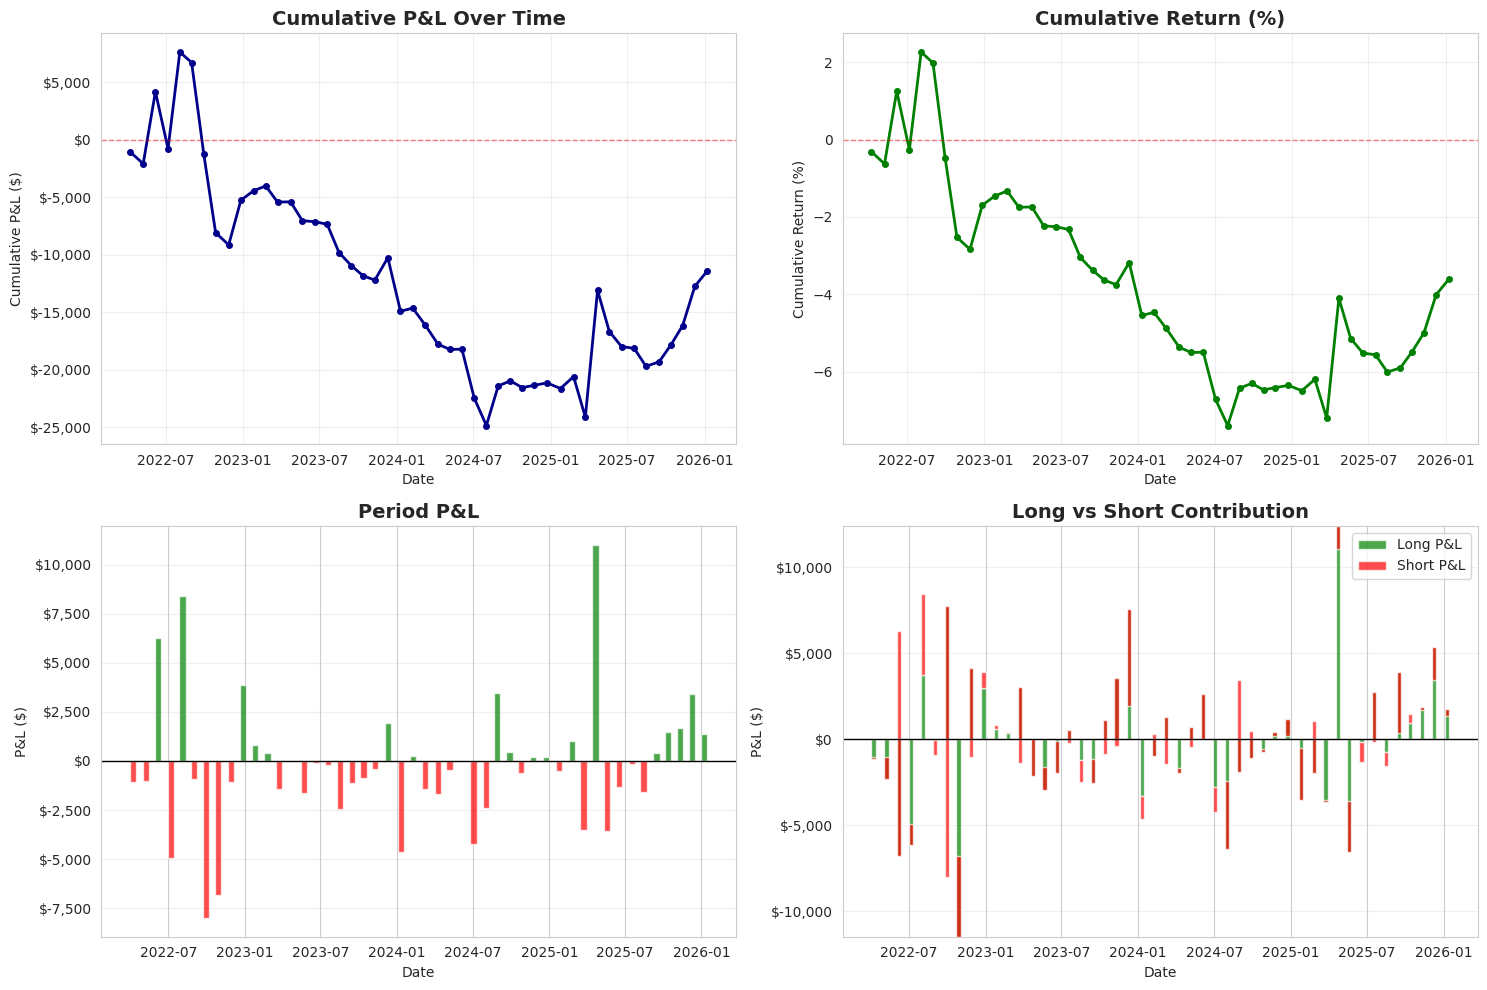


✓ Portfolio performance analysis complete


In [27]:
# Visualize portfolio performance
if returns_df is not None:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Cumulative P&L
    ax = axes[0, 0]
    ax.plot(returns_df['date'], returns_df['cumulative_pnl'], 
            linewidth=2, color='darkblue', marker='o', markersize=4)
    ax.axhline(0, color='red', linestyle='--', linewidth=1, alpha=0.5)
    ax.set_title('Cumulative P&L Over Time', fontsize=14, fontweight='bold')
    ax.set_xlabel('Date')
    ax.set_ylabel('Cumulative P&L ($)')
    ax.grid(True, alpha=0.3)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
    
    # Cumulative Return (%)
    ax = axes[0, 1]
    ax.plot(returns_df['date'], returns_df['cumulative_return'] * 100, 
            linewidth=2, color='green', marker='o', markersize=4)
    ax.axhline(0, color='red', linestyle='--', linewidth=1, alpha=0.5)
    ax.set_title('Cumulative Return (%)', fontsize=14, fontweight='bold')
    ax.set_xlabel('Date')
    ax.set_ylabel('Cumulative Return (%)')
    ax.grid(True, alpha=0.3)
    
    # Period P&L Distribution
    ax = axes[1, 0]
    ax.bar(returns_df['date'], returns_df['total_pnl'], 
           color=['green' if x > 0 else 'red' for x in returns_df['total_pnl']],
           alpha=0.7, width=15)
    ax.axhline(0, color='black', linestyle='-', linewidth=1)
    ax.set_title('Period P&L', fontsize=14, fontweight='bold')
    ax.set_xlabel('Date')
    ax.set_ylabel('P&L ($)')
    ax.grid(True, alpha=0.3, axis='y')
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
    
    # Long vs Short Contribution
    ax = axes[1, 1]
    width = 10
    ax.bar(returns_df['date'], returns_df['long_pnl'], 
           width=width, label='Long P&L', alpha=0.7, color='green')
    ax.bar(returns_df['date'], returns_df['short_pnl'], 
           width=width, label='Short P&L', alpha=0.7, color='red', bottom=returns_df['long_pnl'])
    ax.axhline(0, color='black', linestyle='-', linewidth=1)
    ax.set_title('Long vs Short Contribution', fontsize=14, fontweight='bold')
    ax.set_xlabel('Date')
    ax.set_ylabel('P&L ($)')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
    
    plt.tight_layout()
    plt.show()
    
    print("\n✓ Portfolio performance analysis complete")
else:
    print("No returns to visualize")

## 10. Model Persistence

Save the best model for future use.

In [25]:
# Save best model
model_save_path = f'../models/{best_model_name}_best.pkl'
best_trainer.save_model(model_save_path)

print(f"✓ Best model saved: {model_save_path}")
print(f"  Model type: {best_model_name}")
print(f"  Test R²: {model_results[best_model_name]['metrics']['test_r2']:.4f}")
print(f"  Test RMSE: {model_results[best_model_name]['metrics']['test_rmse']:.6f}")

2026-01-23 18:33:12.377 | INFO     | src.model_trainer:save_model:405 - Model saved to models/../models/ridge_best.pkl


✓ Best model saved: ../models/ridge_best.pkl
  Model type: ridge
  Test R²: 0.0009
  Test RMSE: 0.034894
